In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
import string
import progressbar
from collections import Counter 
from copy import copy
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
warnings.filterwarnings("ignore")

In [ ]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download waelboussbat/flickr8ksau
! unzip /content/flickr8ksau.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k-sau/Flickr_Data/Images/2844747252_64567cf14a.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2848266893_9693c66275.jpg  


In [ ]:
captions_path = "flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
images_path = "flickr8k-sau/Flickr_Data/Images"

In [ ]:
images = os.listdir(images_path)
len(images)

8091

In [ ]:
file = open(captions_path,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [ ]:
df_txt

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


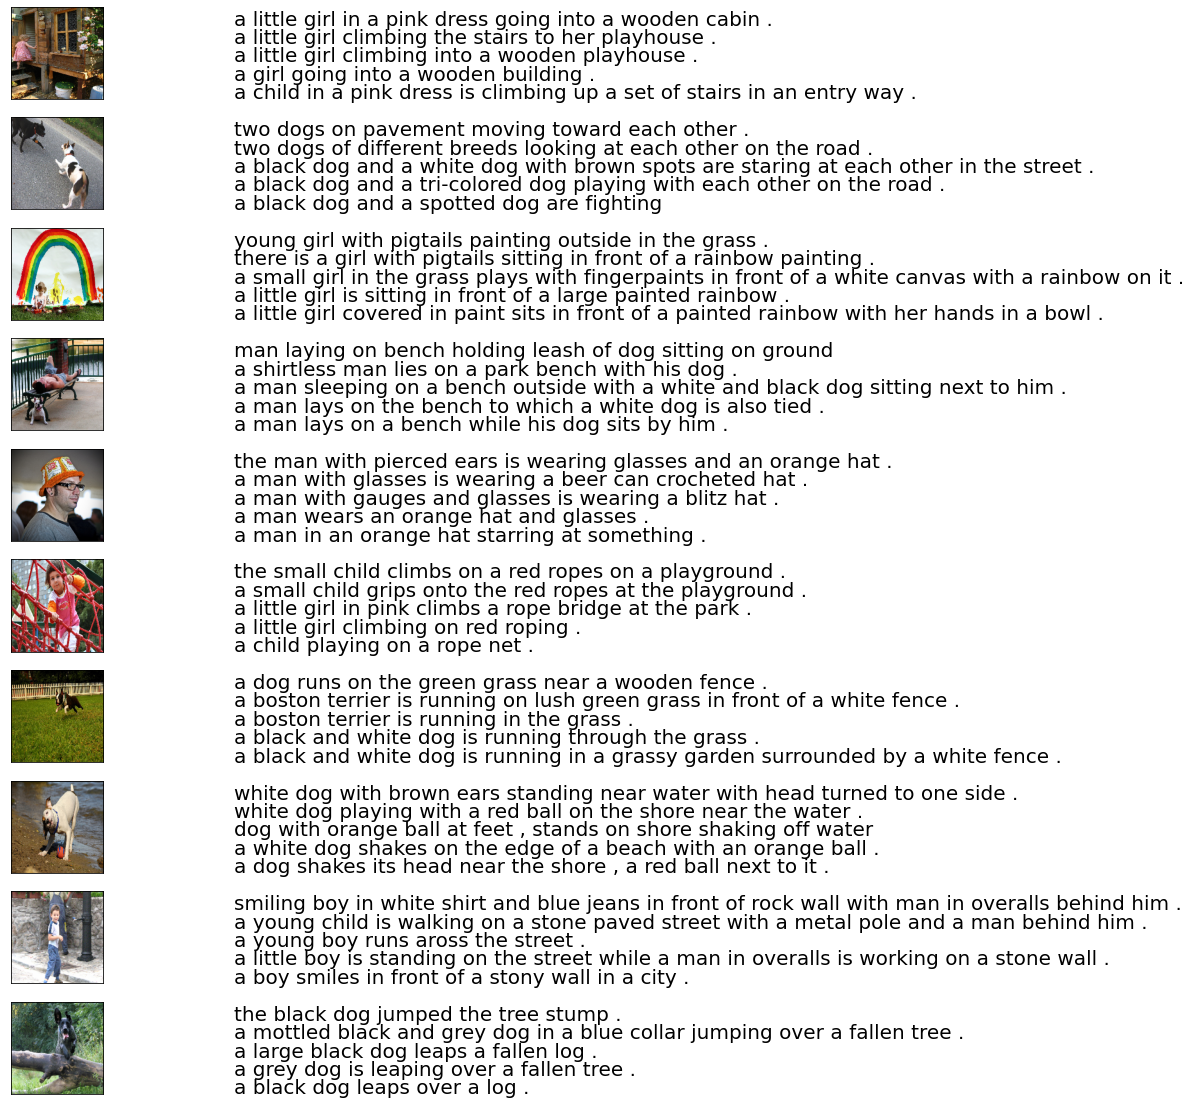

In [ ]:
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:10]:
    filename = images_path + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)

    image_load = load_img(filename, target_size=(224,224,3))
    
    ax = fig.add_subplot(10,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
del uni_filenames

In [ ]:
def df_word(df_txt):
    vocabulary = []

    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())

    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


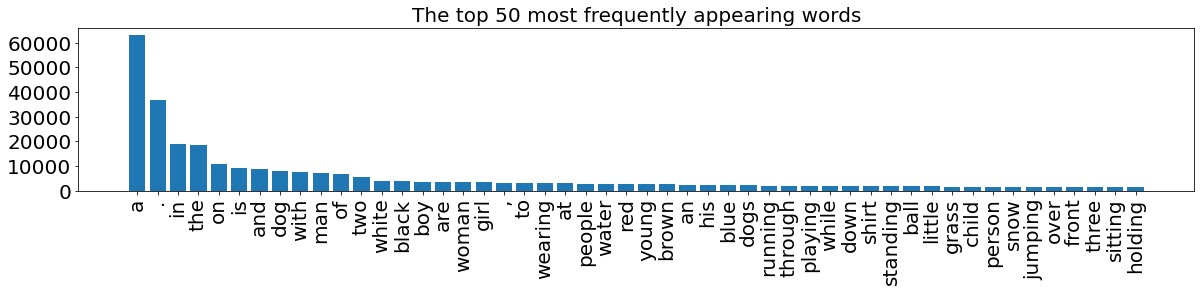

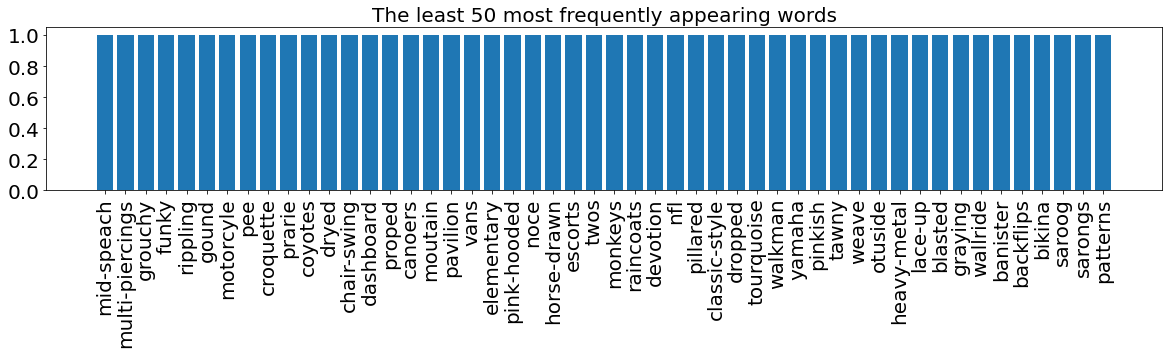

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
del df_word

In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)

100% (40460 of 40460) |##################| Elapsed Time: 0:00:16 Time:  0:00:16


In [ ]:
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df_captions = copy(df_txt)
df_captions["caption"] = add_start_end_seq_token(df_txt["caption"])
del df_txt
df_captions

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,startseq man in pink shirt climbs rock face e...
40456,997722733_0cb5439472.jpg,1,startseq man is rock climbing high in the air...
40457,997722733_0cb5439472.jpg,2,startseq person in red shirt climbing up rock...
40458,997722733_0cb5439472.jpg,3,startseq rock climber in red shirt endseq


In [ ]:
resnet_model = ResNet50(include_top=True)

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
from keras.models import Model
last = resnet_model.layers[-2].output
res_model = Model(inputs = resnet_model.input,outputs = last)
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
images1 = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(images)) as bar:
    for i,name in enumerate(images):
        # load an image from file
        filename = images_path + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = res_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images1[name] = y_pred.flatten()
        bar.update(i)
del images

100% (8091 of 8091) |####################| Elapsed Time: 0:06:57 Time:  0:06:57


In [ ]:
dimages, keepindex = [],[]
df_captions = df_captions.loc[df_captions["index"].values == "0",: ]

for i, fnm in enumerate(df_captions.filename):
    if fnm in images1.keys():
        dimages.append(images1[fnm])
        keepindex.append(i)
        
fnames = df_captions["filename"].iloc[keepindex].values
dcaptions = df_captions["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_captions["index"][:5])

0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


In [ ]:
df_captions

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fighti...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at som...
...,...,...,...
40435,990890291_afc72be141.jpg,0,startseq man does wheelie on his bicycle on t...
40440,99171998_7cc800ceef.jpg,0,startseq group is sitting around snowy crevas...
40445,99679241_adc853a5c0.jpg,0,startseq grey bird stands majestically on bea...
40450,997338199_7343367d7f.jpg,0,startseq person stands near golden walls endseq


In [ ]:
del keepindex

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
Ntest = int(len(dtexts)*0.2)

def split_test_train(dtexts,Ntest):
    return(dtexts[:Ntest],  
           dtexts[Ntest:])

dt_test, dt_train   = split_test_train(dtexts,Ntest)
di_test, di_train   = split_test_train(dimages,Ntest)
fnm_test, fnm_train  = split_test_train(fnames,Ntest)

In [ ]:
del df_captions
del images1

In [ ]:
maxlen = np.max([len(text) for text in dtexts])

In [ ]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)

# captions/images = 6473
 (65984, 30) (65984, 2048) (65984, 4476)


In [ ]:
from keras import layers
from keras.regularizers import l2
from keras import models

print(vocab_size)
## image feature

dim_embedding = 128

input_image = layers.Input(shape=(Ximage_train.shape[1],))
droplayer1 = layers.Dropout(0.5)(input_image)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature1",kernel_regularizer=l2(0.01))(BN)
droplayer1 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature3",kernel_regularizer=l2(0.01))(BN)
droplayer2 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer2)
fimage2 = layers.Dense(256, activation='relu')(BN)


## sequence model
input_txt = layers.Input(shape=(np.max([len(text) for text in dtexts]),))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
droplayer_ = layers.Dropout(0.5)(ftxt)
BN = layers.BatchNormalization()(droplayer_)
ftxt = layers.LSTM(256,name="CaptionFeature")(BN)


## combined model for decoder
decoder = layers.add([ftxt,fimage2])
decoder = layers.Dense(256,activation='relu')(decoder)
droplayer1 = layers.Dropout(0.5)(decoder)
BN = layers.BatchNormalization()(droplayer1)
output = layers.Dense(vocab_size,activation='softmax')(BN)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

4476
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_5 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 2048)        8192        ['dropout_5[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 ImageFeature1 (Dense)          (None, 256)          524544      ['batch_normalization_

In [ ]:
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=100, verbose=2, 
                  batch_size=100,
                  validation_split=0.1)

Epoch 1/100
528/528 - 37s - loss: 5.1830 - accuracy: 0.2368 - val_loss: 4.8495 - val_accuracy: 0.2583 - 37s/epoch - 70ms/step
Epoch 2/100
528/528 - 35s - loss: 4.6948 - accuracy: 0.2620 - val_loss: 4.6512 - val_accuracy: 0.2679 - 35s/epoch - 67ms/step
Epoch 3/100
528/528 - 35s - loss: 4.4353 - accuracy: 0.2756 - val_loss: 4.5192 - val_accuracy: 0.2848 - 35s/epoch - 67ms/step
Epoch 4/100
528/528 - 35s - loss: 4.2239 - accuracy: 0.2857 - val_loss: 4.4905 - val_accuracy: 0.2871 - 35s/epoch - 67ms/step
Epoch 5/100
528/528 - 35s - loss: 4.0575 - accuracy: 0.2948 - val_loss: 4.4652 - val_accuracy: 0.2943 - 35s/epoch - 66ms/step
Epoch 6/100
528/528 - 35s - loss: 3.9422 - accuracy: 0.2997 - val_loss: 4.4388 - val_accuracy: 0.2979 - 35s/epoch - 67ms/step
Epoch 7/100
528/528 - 35s - loss: 3.8458 - accuracy: 0.3048 - val_loss: 4.4581 - val_accuracy: 0.3007 - 35s/epoch - 66ms/step
Epoch 8/100
528/528 - 35s - loss: 3.7587 - accuracy: 0.3104 - val_loss: 4.4431 - val_accuracy: 0.3023 - 35s/epoch - 66

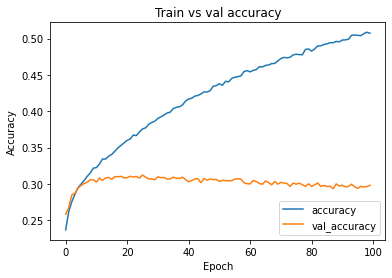

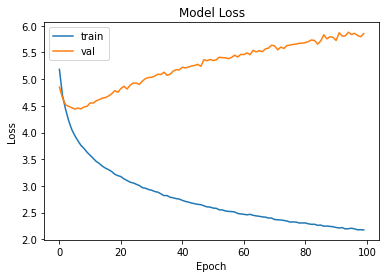

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model

embedding_size = 128
max_len = 30

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           572928    
                                                                 
 lstm (LSTM)                 (None, 30, 256)           394240    
                            

In [ ]:
histry = model.fit([Ximage_train, Xtext_train], ytext_train, validation_split=0.05, batch_size=128, epochs=100)

Epoch 1/100
552/552 [==============================] - 19s 25ms/step - loss: 5.5007 - accuracy: 0.1405 - val_loss: 4.8627 - val_accuracy: 0.1902
Epoch 2/100
552/552 [==============================] - 13s 23ms/step - loss: 4.5696 - accuracy: 0.2194 - val_loss: 4.5478 - val_accuracy: 0.2257
Epoch 3/100
552/552 [==============================] - 13s 23ms/step - loss: 4.2309 - accuracy: 0.2389 - val_loss: 4.4503 - val_accuracy: 0.2351
Epoch 4/100
552/552 [==============================] - 13s 23ms/step - loss: 3.9864 - accuracy: 0.2568 - val_loss: 4.3436 - val_accuracy: 0.2458
Epoch 5/100
552/552 [==============================] - 13s 23ms/step - loss: 3.7675 - accuracy: 0.2730 - val_loss: 4.2913 - val_accuracy: 0.2569
Epoch 6/100
552/552 [==============================] - 13s 23ms/step - loss: 3.5671 - accuracy: 0.2880 - val_loss: 4.2709 - val_accuracy: 0.2649
Epoch 7/100
552/552 [==============================] - 13s 23ms/step - loss: 3.3811 - accuracy: 0.3031 - val_loss: 4.2422 - val_ac

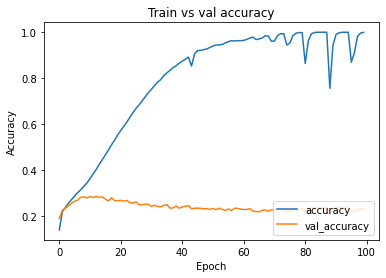

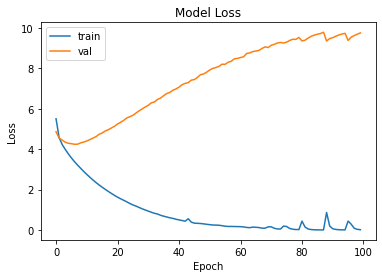

In [ ]:
plt.plot(histry.history['accuracy'], label='accuracy')
plt.plot(histry.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.show()

plt.plot(histry.history['loss'])
plt.plot(histry.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# image features extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
 
# input sequence model
inputs2 = Input(shape=(maxlen,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model OR output word model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model3 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize model
model3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 30, 256)      1145856     ['input_5[0][0]']                
                                                                                                  
 dropout_19 (Dropout)           (None, 2048)         0           ['input_4[0][0]']                
                                                                                           

In [ ]:
history3 = model3.fit([Ximage_train, Xtext_train], ytext_train, validation_split=0.1, batch_size=128, epochs=100)

Epoch 1/100
523/523 [==============================] - 58s 100ms/step - loss: 5.1945 - accuracy: 0.1724 - val_loss: 4.5209 - val_accuracy: 0.2348
Epoch 2/100
523/523 [==============================] - 50s 95ms/step - loss: 4.1741 - accuracy: 0.2588 - val_loss: 4.1928 - val_accuracy: 0.2704
Epoch 3/100
523/523 [==============================] - 52s 100ms/step - loss: 3.7502 - accuracy: 0.2897 - val_loss: 4.0960 - val_accuracy: 0.2905
Epoch 4/100
523/523 [==============================] - 50s 96ms/step - loss: 3.4692 - accuracy: 0.3059 - val_loss: 4.0895 - val_accuracy: 0.2946
Epoch 5/100
523/523 [==============================] - 49s 94ms/step - loss: 3.2399 - accuracy: 0.3203 - val_loss: 4.1477 - val_accuracy: 0.2979
Epoch 6/100
523/523 [==============================] - 49s 94ms/step - loss: 3.0366 - accuracy: 0.3320 - val_loss: 4.2036 - val_accuracy: 0.3016
Epoch 7/100
523/523 [==============================] - 50s 95ms/step - loss: 2.8517 - accuracy: 0.3485 - val_loss: 4.3145 - val_

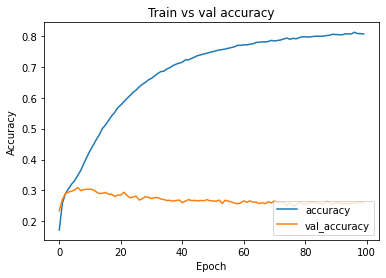

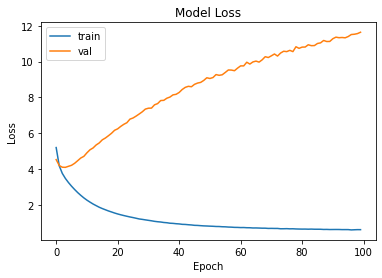

In [ ]:
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

embedding_size = 300

image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(30))

sequence_model = Sequential()
sequence_model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
sequence_model.add(LSTM(256, return_sequences=True))
sequence_model.add(TimeDistributed(Dense(300)))

conc = Concatenate()([image_model.output, sequence_model.output])
x = Bidirectional(LSTM(256, return_sequences=False))(conc)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)

model4 = Model(inputs=[image_model.input, sequence_model.input], outputs = out)
model4.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model4.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_13_input (InputLayer  [(None, 30)]        0           []                               
 )                                                                                                
                                                                                                  
 dense_43_input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 30, 300)      1342800     ['embedding_13_input[0][0]']     
                                                                                                  
 dense_43 (Dense)               (None, 300)          614700      ['dense_43_input[0][0]']  

In [ ]:
history4 = model4.fit([Ximage_train, Xtext_train], ytext_train, validation_split=0.1, batch_size=128, epochs=100)

Epoch 1/100
523/523 [==============================] - 21s 28ms/step - loss: 5.2241 - accuracy: 0.1711 - val_loss: 4.6865 - val_accuracy: 0.2239
Epoch 2/100
523/523 [==============================] - 13s 25ms/step - loss: 4.4237 - accuracy: 0.2485 - val_loss: 4.3370 - val_accuracy: 0.2540
Epoch 3/100
523/523 [==============================] - 13s 26ms/step - loss: 4.1448 - accuracy: 0.2762 - val_loss: 4.2570 - val_accuracy: 0.2692
Epoch 4/100
523/523 [==============================] - 14s 26ms/step - loss: 3.9868 - accuracy: 0.2918 - val_loss: 4.2016 - val_accuracy: 0.2762
Epoch 5/100
523/523 [==============================] - 13s 25ms/step - loss: 3.8562 - accuracy: 0.3041 - val_loss: 4.1586 - val_accuracy: 0.2886
Epoch 6/100
523/523 [==============================] - 13s 25ms/step - loss: 3.7565 - accuracy: 0.3133 - val_loss: 4.1987 - val_accuracy: 0.2903
Epoch 7/100
523/523 [==============================] - 13s 25ms/step - loss: 3.6772 - accuracy: 0.3229 - val_loss: 4.2053 - val_ac

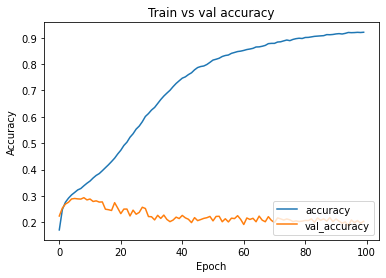

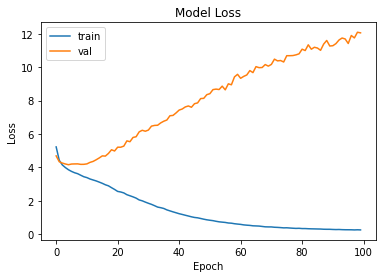

In [ ]:
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

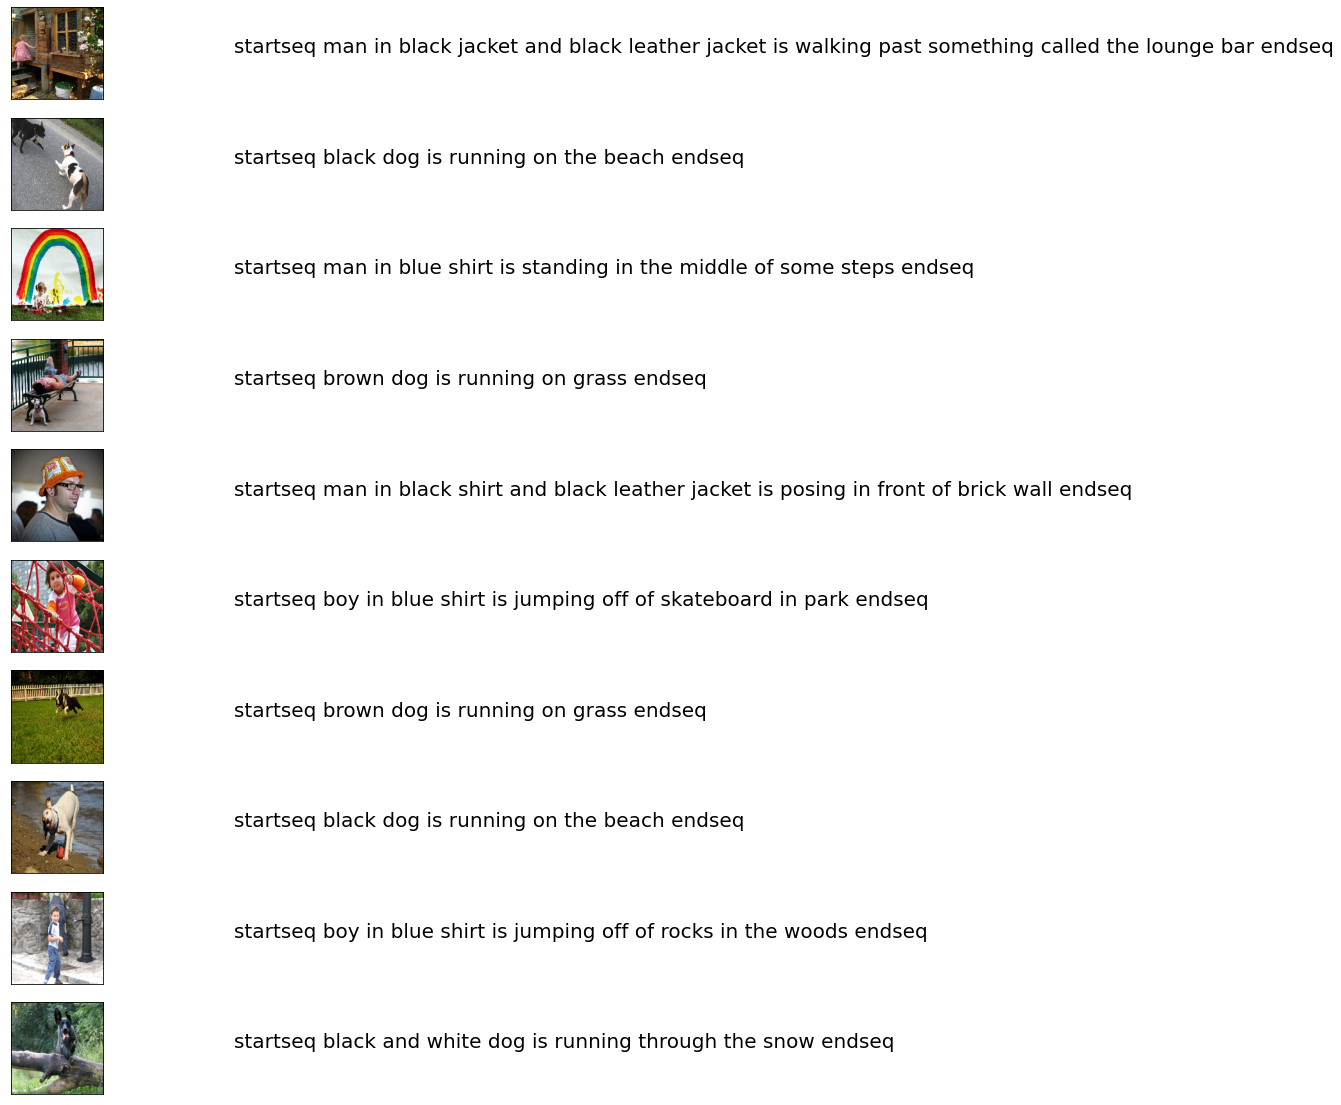

In [ ]:
npic = 10
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):

    ## images 
    filename = images_path + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 20
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    
    if bleu > 0.5 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.2 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [ ]:
def plot_images(pred_bad):

    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)

    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)

    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        filename = images_path + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

Good Captions


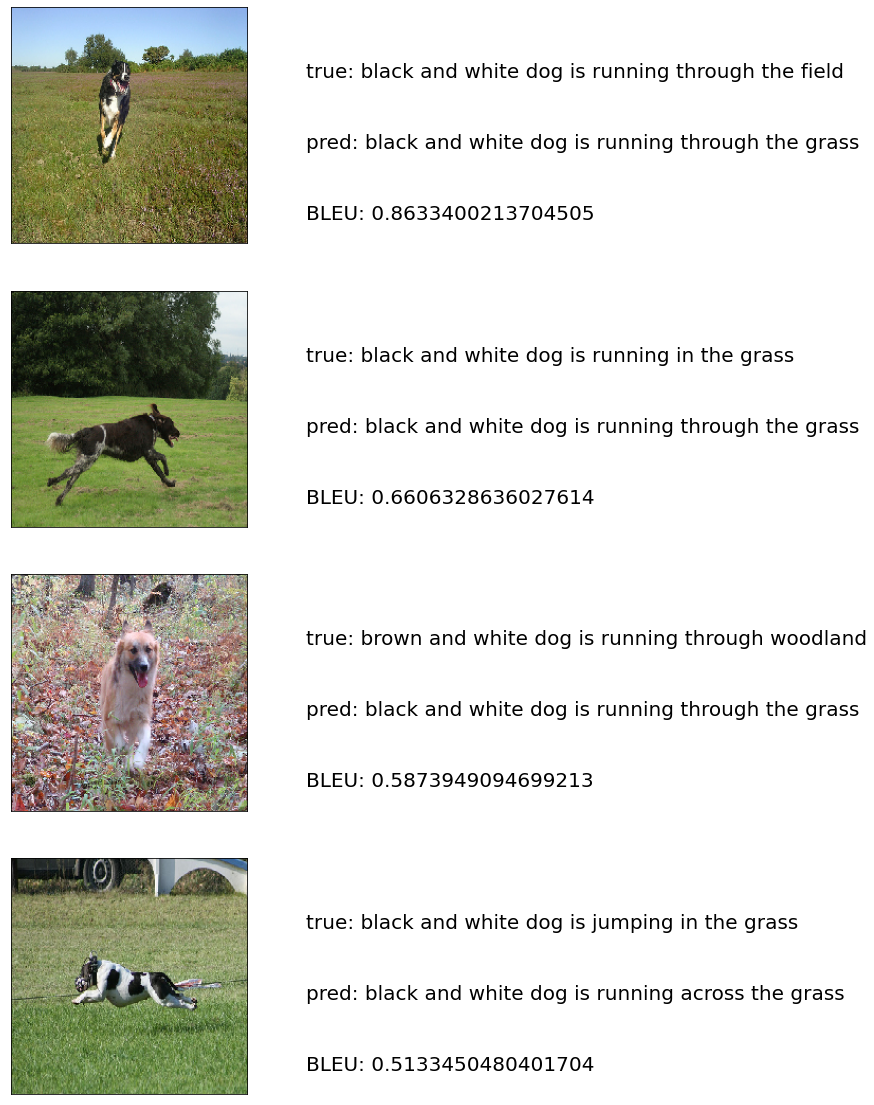

In [ ]:
print("Good Captions")
plot_images(pred_good)

Bad Captions


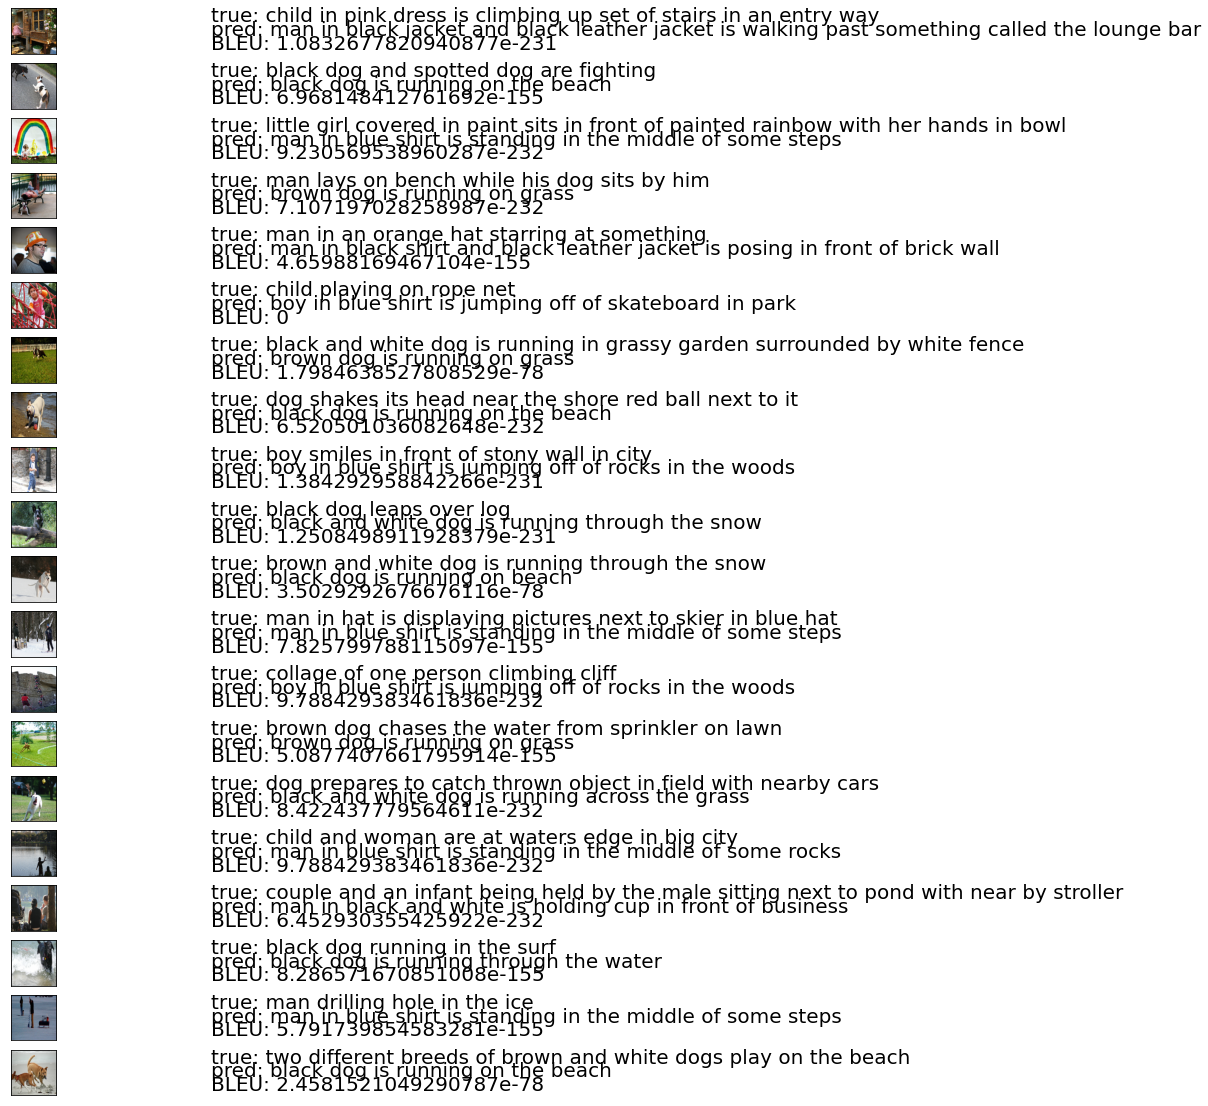

In [ ]:
print("Bad Captions")
plot_images(pred_bad)